In this Lab Program we are going to Sampling and Quantization for an audio file i.e the single Speech signal Taken from TIMIT also known to be as Texas Instruments/Massachusetts Institute of Technology which is phonemically and lexically Transcribed speech of Various different

In [1]:
!pip install gtts

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from gtts import gTTS

In [3]:
text="A dog is the only thing on earth that loves you more than you love yourself."
language='en'
output='output.wav'

#convert the text to audio file using librosa
tts=gTTS(text=text,lang=language,slow=False)
tts.save(output)


In [4]:
audio_file="/content/drive/MyDrive/output.wav"
#load the audio file
original_audio, sr = librosa.load(audio_file, sr=None)

In [5]:
!pip install pydub
!pip install SpeechRecognition

In [6]:
#convert the audiowav to text
import speech_recognition as sr
r = sr.Recognizer()
with sr.AudioFile(audio_file) as source:
    audio = r.record(source)
try:
    print("Transcription: " + r.recognize_google(audio))
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))


Transcription: a dog is the only thing on Earth that loves you more than you love yourself


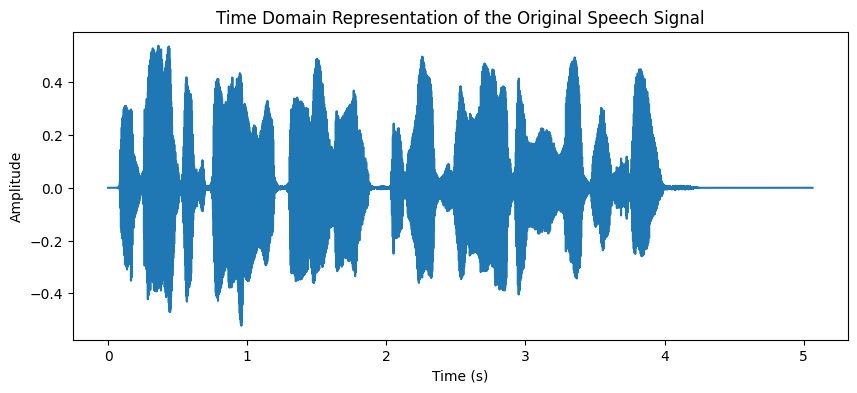

In [7]:
#a) Plot the time domain representation of the original speech signal.
plt.figure(figsize=(10, 4))
wav_file="/content/drive/MyDrive/output.wav"
speech_signal, sr = librosa.load(wav_file, sr=None)
t=np.linspace(0,len(speech_signal)/sr,len(speech_signal))
plt.plot(t,speech_signal)
# librosa.display.waveshow(original_audio, sr=sr)
plt.title('Time Domain Representation of the Original Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


######          Sampling : it basically defines the process of converting the continuous analogue Signals to Discrete Time Signal by taking periodic measurements of the amplitude of the signals i.e speech signals are continuous in nature in theit natural form for each and every possible value point in time  
######Let us consider Ts representing the time signal which is anlogue recorded at regular intervals During sampling, the value of the source signal is measured mathematically let us take x(t) being the continuous time signal of speech i.e Ts=1/fs being the sampling interval and fs is the sampling frequency

######and mathematical expression  is given below -x[n]=x(nTs) for n=0,1,2,...t

In [8]:
# Sampling the speech signals at different sampling rates
rates = [8000, 16000, 44100]
sampled_signals = {}

for rate in rates:
    # Pass the audio data (speech_signal) to the y parameter
    sampled_signal = librosa.resample(y=speech_signal, orig_sr=sr, target_sr=rate)
    sampled_signals[rate] = sampled_signal

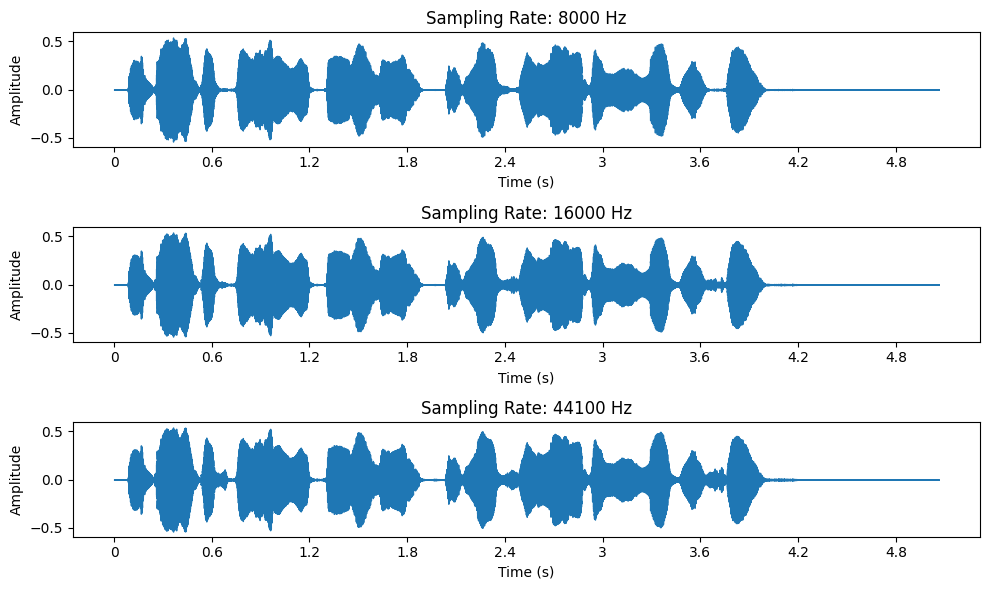

In [9]:
#c)Plot the sampling Speech for each sampling rate
plt.figure(figsize=(10, 6))
for rate, signal in sampled_signals.items():
    plt.subplot(len(rates), 1, rates.index(rate) + 1)
    librosa.display.waveshow(signal, sr=rate)
    plt.title(f'Sampling Rate: {rate} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#### Zero-Order hold or say nearest interpolation method is used to reconstruct a continuous Signal fron the discrete samples ,in Sero order hold Each sample is held out to be constant and until the next sample is received, forming a step-like function.Working of Zero order hold interpolation where we take each sample and hold that sample value until the next sample value arrives
mathematically for discrete Time signal x[n] with time sampling Ts
the ZOH can be represented as
xZOH(t)=x[n], nTs<=t<(n+1)Ts



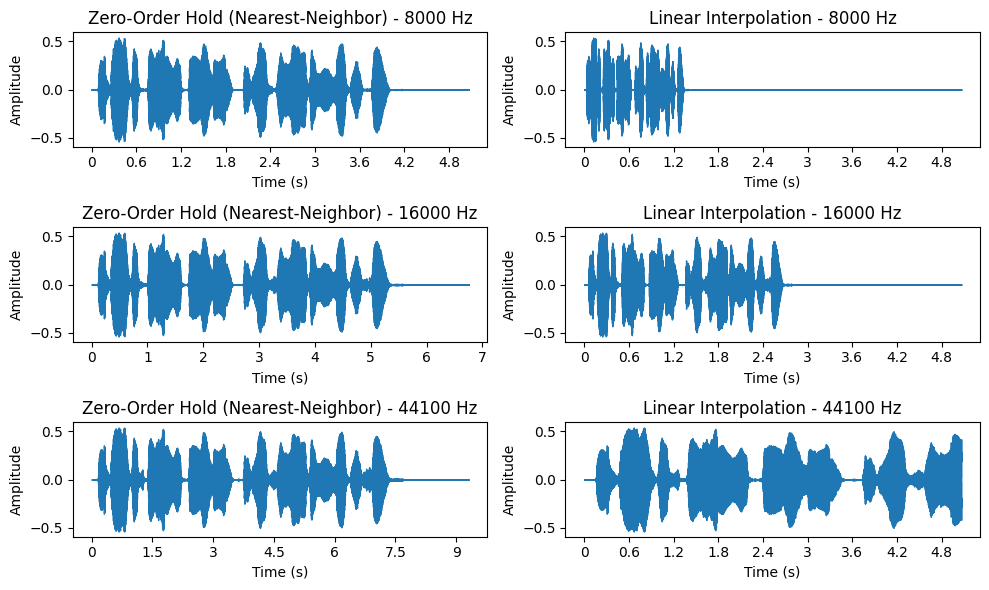

In [10]:
def reconstruct_signals(speech_signal, sr, rates):


  reconstructed_signals = {}
  for rate in rates:
    sampled_signal = librosa.resample(y=speech_signal, orig_sr=sr, target_sr=rate)

    # Zero-order hold reconstruction
    # Use np.ceil to ensure the repeat value is at least 1
    repeat_count = int(np.ceil(sr / rate))
    zero_order_hold = np.repeat(sampled_signal, repeat_count)  # Efficient repeat
    reconstructed_signals[rate] = {'zero_order_hold': zero_order_hold}

    # Linear interpolation reconstruction
    orig_indices = np.linspace(0, len(speech_signal) - 1, len(speech_signal))  # Create original indices
    sampled_indices = np.linspace(0, len(sampled_signal) - 1, len(sampled_signal))
    linear_interpolation = interp1d(sampled_indices, sampled_signal, kind='linear', fill_value='extrapolate')
    reconstructed_signals_linear = linear_interpolation(orig_indices)
    reconstructed_signals[rate].update({'linear_interpolation': reconstructed_signals_linear})

  return reconstructed_signals

rates = [8000, 16000, 44100]
reconstructed_signals = reconstruct_signals(speech_signal, sr, rates)

# Plot the reconstructed signals (loop through each rate)
plt.figure(figsize=(10, 6))
for i, rate in enumerate(rates):
  zero_order_hold = reconstructed_signals[rate]['zero_order_hold']
  linear_interpolation = reconstructed_signals[rate]['linear_interpolation']

  plt.subplot(len(rates), 2, 2 * i + 1)
  librosa.display.waveshow(zero_order_hold, sr=sr)
  plt.title(f'Zero-Order Hold (Nearest-Neighbor) - {rate} Hz')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')

  plt.subplot(len(rates), 2, 2 * i + 2)
  librosa.display.waveshow(linear_interpolation, sr=sr)
  plt.title(f'Linear Interpolation - {rate} Hz')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [11]:
# prompt: #Calculate the Mean Squared Error (MSE) between the original and the reconstructed signals for both methods.

mse_results = {}
for rate in rates:
  mse_results[rate] = {}
  zero_order_hold = reconstructed_signals[rate]['zero_order_hold']
  linear_interpolation = reconstructed_signals[rate]['linear_interpolation']

  # Ensure the lengths of the signals match before calculating MSE
  if len(zero_order_hold) > len(speech_signal):
    zero_order_hold = zero_order_hold[:len(speech_signal)]
  elif len(speech_signal) > len(zero_order_hold):
    speech_signal = speech_signal[:len(zero_order_hold)]

  if len(linear_interpolation) > len(speech_signal):
    linear_interpolation = linear_interpolation[:len(speech_signal)]
  elif len(speech_signal) > len(linear_interpolation):
    speech_signal = speech_signal[:len(linear_interpolation)]

  mse_results[rate]['zero_order_hold'] = mean_squared_error(speech_signal, zero_order_hold)
  mse_results[rate]['linear_interpolation'] = mean_squared_error(speech_signal, linear_interpolation)

# Print the MSE results
for rate, mse_values in mse_results.items():
  print(f"Sampling Rate: {rate} Hz")
  print(f"  Zero-Order Hold MSE: {mse_values['zero_order_hold']}")
  print(f"  Linear Interpolation MSE: {mse_values['linear_interpolation']}")


Sampling Rate: 8000 Hz
  Zero-Order Hold MSE: 0.000550713564734906
  Linear Interpolation MSE: 0.017216749271675328
Sampling Rate: 16000 Hz
  Zero-Order Hold MSE: 0.02996358834207058
  Linear Interpolation MSE: 0.0216069511050338
Sampling Rate: 44100 Hz
  Zero-Order Hold MSE: 0.031023571267724037
  Linear Interpolation MSE: 0.031023572446619203


to conclude we see the as we lower the mean squared error lesser the dispersion of points when we compare it to the sampling rate of 8000 Hz to linear interpolation   as we go further with the increasing in  sampling rate  linear interpolation gives a better results as the sampling points lie closer to each other also moving further we see sampling rate of Zero hold and linear interpolation is same
at higher the sampling rate it itself plays a crucuial role in reducing the reconstruction errors thus making interpolation technique less significant


i,e lesser the sampling rate

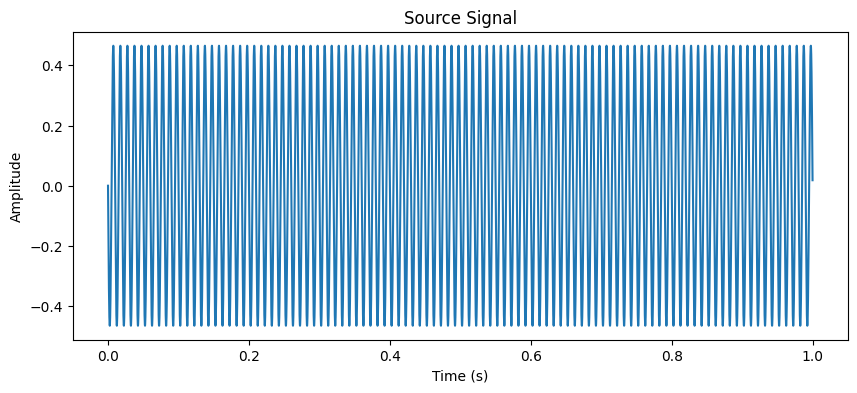

In [12]:
#@title 2)Implement the source-filter Model for a given speech signal and analyze the impact of sampling and reconstruction on the quality of the speech signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from scipy.signal import resample


def generate_source_signal(signal_type="Voiced",duration=1.0,fs=16000,f0=100):
  t=np.linspace(0,duration,int(duration*fs),endpoint=False)
  if signal_type=="Voiced":
    source_signal=np.sin(2*np.pi*f0*t)*(np.random.randn(int(len(t)>0.5)))
  elif signal_type=="Unvoiced":
    source_signal=np.random.randn(len(t))
  return t,source_signal

#generate the source signal
t,source_signal=generate_source_signal()

#plot the source signal
plt.figure(figsize=(10, 4))
plt.plot(t,source_signal)
plt.title('Source Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

a source filter model in the context of speech processing it is in 2 parts  we have a source which is the excitation signal (voiced or unvoiced ) and filter represents the voice tract

Generate the source Signal can be either voiced and unvoiced (modeled as white noise )

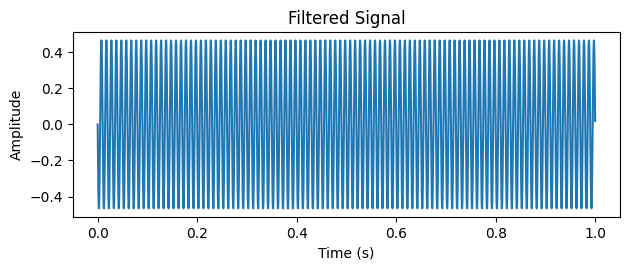

In [13]:
#step 2 Apply the Vocal Tract Filter
def apply_vocal_tract_filter(source_signal,fs=16000):
  #defining the resonants and bandwidth
  formant_freqs = [500, 1500, 2500]
  bandwidths = [50, 100, 150]

  # Create an all-pole filter
  b = [1.0]  # Numerator (all-pole filter has 1 as numerator)
  a = [1.0]


  for f, bw in zip(formant_freqs, bandwidths):
    r=np.exp(-np.pi*bw/fs)
    theta=2*np.pi*f/fs
    pole=[1,-2*r*np.cos(theta),r**2]
    a=np.convolve(a,pole)
    b=np.convolve(b,pole)

  #apply the filter
  filtered_signal=lfilter(b,a,source_signal)
  return filtered_signal


#plot the filtered signal
filtered_signal = apply_vocal_tract_filter(source_signal)

plt.subplot(2, 1, 2)
plt.plot(t, filtered_signal)
plt.title('Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

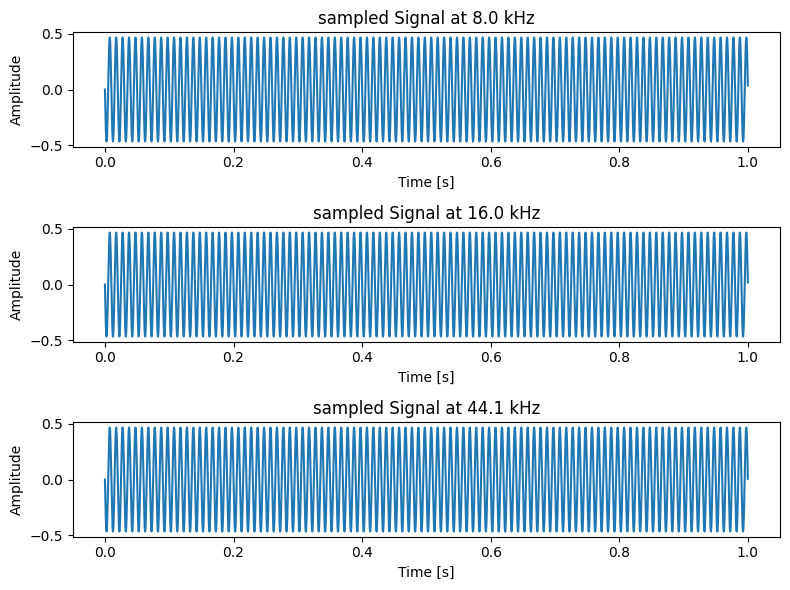

In [14]:
#Sampling at different rates


#Sampling at different rates
def sample_signal(signal,fs,target_fs):
  n_samples=int(len(signal)*target_fs/fs)
  sampled_signal=resample(signal,n_samples)
  return sampled_signal

# Sample the signal at different rates # This section was indented inside the function
fs = 16000 # Define the original sampling frequency
duration = 1.0 # Define the duration
fs_list = [8000, 16000, 44100]
sampled_signals = {fs_new: sample_signal(filtered_signal, fs, fs_new) for fs_new in fs_list}

# Plot the sampled signals
plt.figure(figsize=(8, 6))
for i, (fs_new, sig) in enumerate(sampled_signals.items()):
    t_new = np.linspace(0, duration, len(sig), endpoint=False)
    plt.subplot(len(fs_list), 1, i+1)
    plt.plot(t_new, sig)
    plt.title(f"sampled Signal at {fs_new / 1000} kHz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


In [17]:
def reconstruct_signal(signal, duration, method='linear', original_fs=16000, target_fs=16000):
    t_original = np.linspace(0, duration, len(signal), endpoint=False)
    t_reconstructed = np.linspace(0, duration, int(duration * target_fs), endpoint=False)

    if method == 'linear':
        reconstructed_signal = np.interp(t_reconstructed, t_original, signal)
    elif method == 'zero_order_hold':
        indices = np.floor(t_reconstructed / (1 / original_fs)).astype(int)
        reconstructed_signal = signal[indices]
    else:
        raise ValueError("Method should be 'linear' or 'zero_order_hold'.")

    return reconstructed_signal


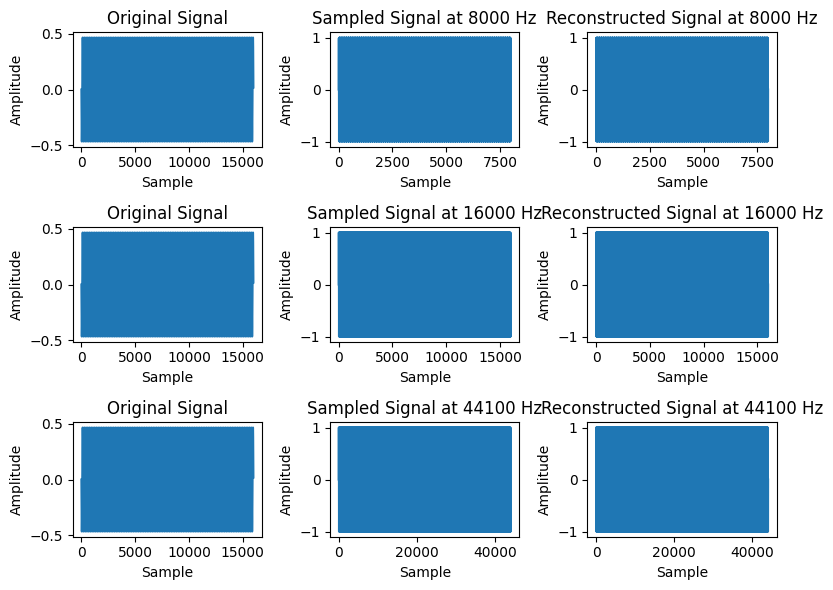

In [23]:
# Reconstruct the sampled signals
reconstructed_signals = {}
for fs_new in sampled_signals: # Iterate over the keys of sampled_signals which contains the sampling rates
    reconstructed_signals[fs_new] = reconstruct_signal(sampled_signals[fs_new], duration, method='linear', original_fs=fs, target_fs=fs_new)

# Plot the original, sampled, and reconstructed signals
plt.figure(figsize=(8, 6))

for i, fs_new in enumerate(sampled_signals): # Iterate over the keys of sampled_signals
    plt.subplot(len(sampled_signals), 3, 3*i + 1) # Use len(sampled_signals) to determine the number of subplots
    plt.plot(filtered_signal)
    plt.title('Original Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(len(sampled_signals), 3, 3*i + 2) # Use len(sampled_signals) to determine the number of subplots
    plt.plot(sampled_signals[fs_new])
    plt.title(f'Sampled Signal at {fs_new} Hz')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(len(sampled_signals), 3, 3*i + 3) # Use len(sampled_signals) to determine the number of subplots
    plt.plot(reconstructed_signals[fs_new])
    plt.title(f'Reconstructed Signal at {fs_new} Hz')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [26]:
# Step 5: Compute Mean Squared Error (MSE)
def compute_mse(original_signal, reconstructed_signal):
    # Ensure the signals are of the same length
    min_len = min(len(original_signal), len(reconstructed_signal))
    original_signal = original_signal[:min_len]
    reconstructed_signal = reconstructed_signal[:min_len]

    mse = np.mean((original_signal - reconstructed_signal) ** 2)
    return mse

# Compute MSE for each sampled signal
mse_results = {}
#Iterate over the keys in reconstructed_signals which are the sampling rates
for fs_new in reconstructed_signals:
    mse = compute_mse(filtered_signal[:len(reconstructed_signals[fs_new])], reconstructed_signals[fs_new])
    mse_results[fs_new] = mse

# Print MSE results
for fs_new, mse in mse_results.items():
    print(f'MSE for {fs_new} Hz: {mse:.4f}')

MSE for 8000 Hz: 0.6081
MSE for 16000 Hz: 0.6081
MSE for 44100 Hz: 0.6071


Here in the source filter basically does the simulation of voiced and unvoiced by implementing vocal tract filter when considering the speech decreasing the sampling rates reduces the quality of the signal

inference from the above : if the MSE values are lower for higher sampling rates (e.g., 44.1 kHz compared to 8 kHz), it indicates that the quality of the reconstructed signal improves with higher sampling rates. This is because higher sampling rates capture more details of the original signal, leading to a more accurate reconstruction.

and if the MSE values are higher for lower sampling rates, it suggests that the lower sampling rate results in more significant loss of detail and accuracy during reconstruction.